In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import PyCO2SYS as pyco2
from scipy.interpolate import PchipInterpolator

df = pd.read_csv("../../compilation/data/in_situ_rates_compiled_allvar_uncertainty.csv")

# fill all nan errors with 0
df['Rate_error_sa'] = df['Rate_error_sa'].fillna(0)
df['Rate_error_mass'] = df['Rate_error_mass'].fillna(0)

# only m77
df_m77 = df[(df['Source_abbrev'] == 'M77')]

## Dissolution as function of depth (Figure S16)

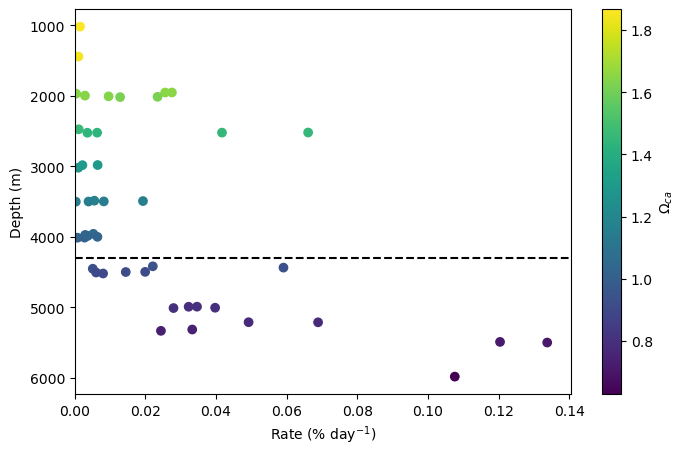

In [2]:
plt.figure(figsize=(8,5))
df_m77_m = df_m77[df_m77.Material == 'Calcite']
plt.scatter(df_m77_m['Rate_mass'], df_m77_m['Depth'], c=df_m77_m['Omega_calc23'])

plt.ylabel('Depth (m)')
plt.xlabel("Rate (% day$^{-1}$)")
plt.xlim(0)
plt.gca().invert_yaxis()
plt.colorbar(label='$\Omega_{ca}$')
plt.axhline(4300, color='black', linestyle='--')
plt.show()

## Dissolution as function of Ω (Figure 10)

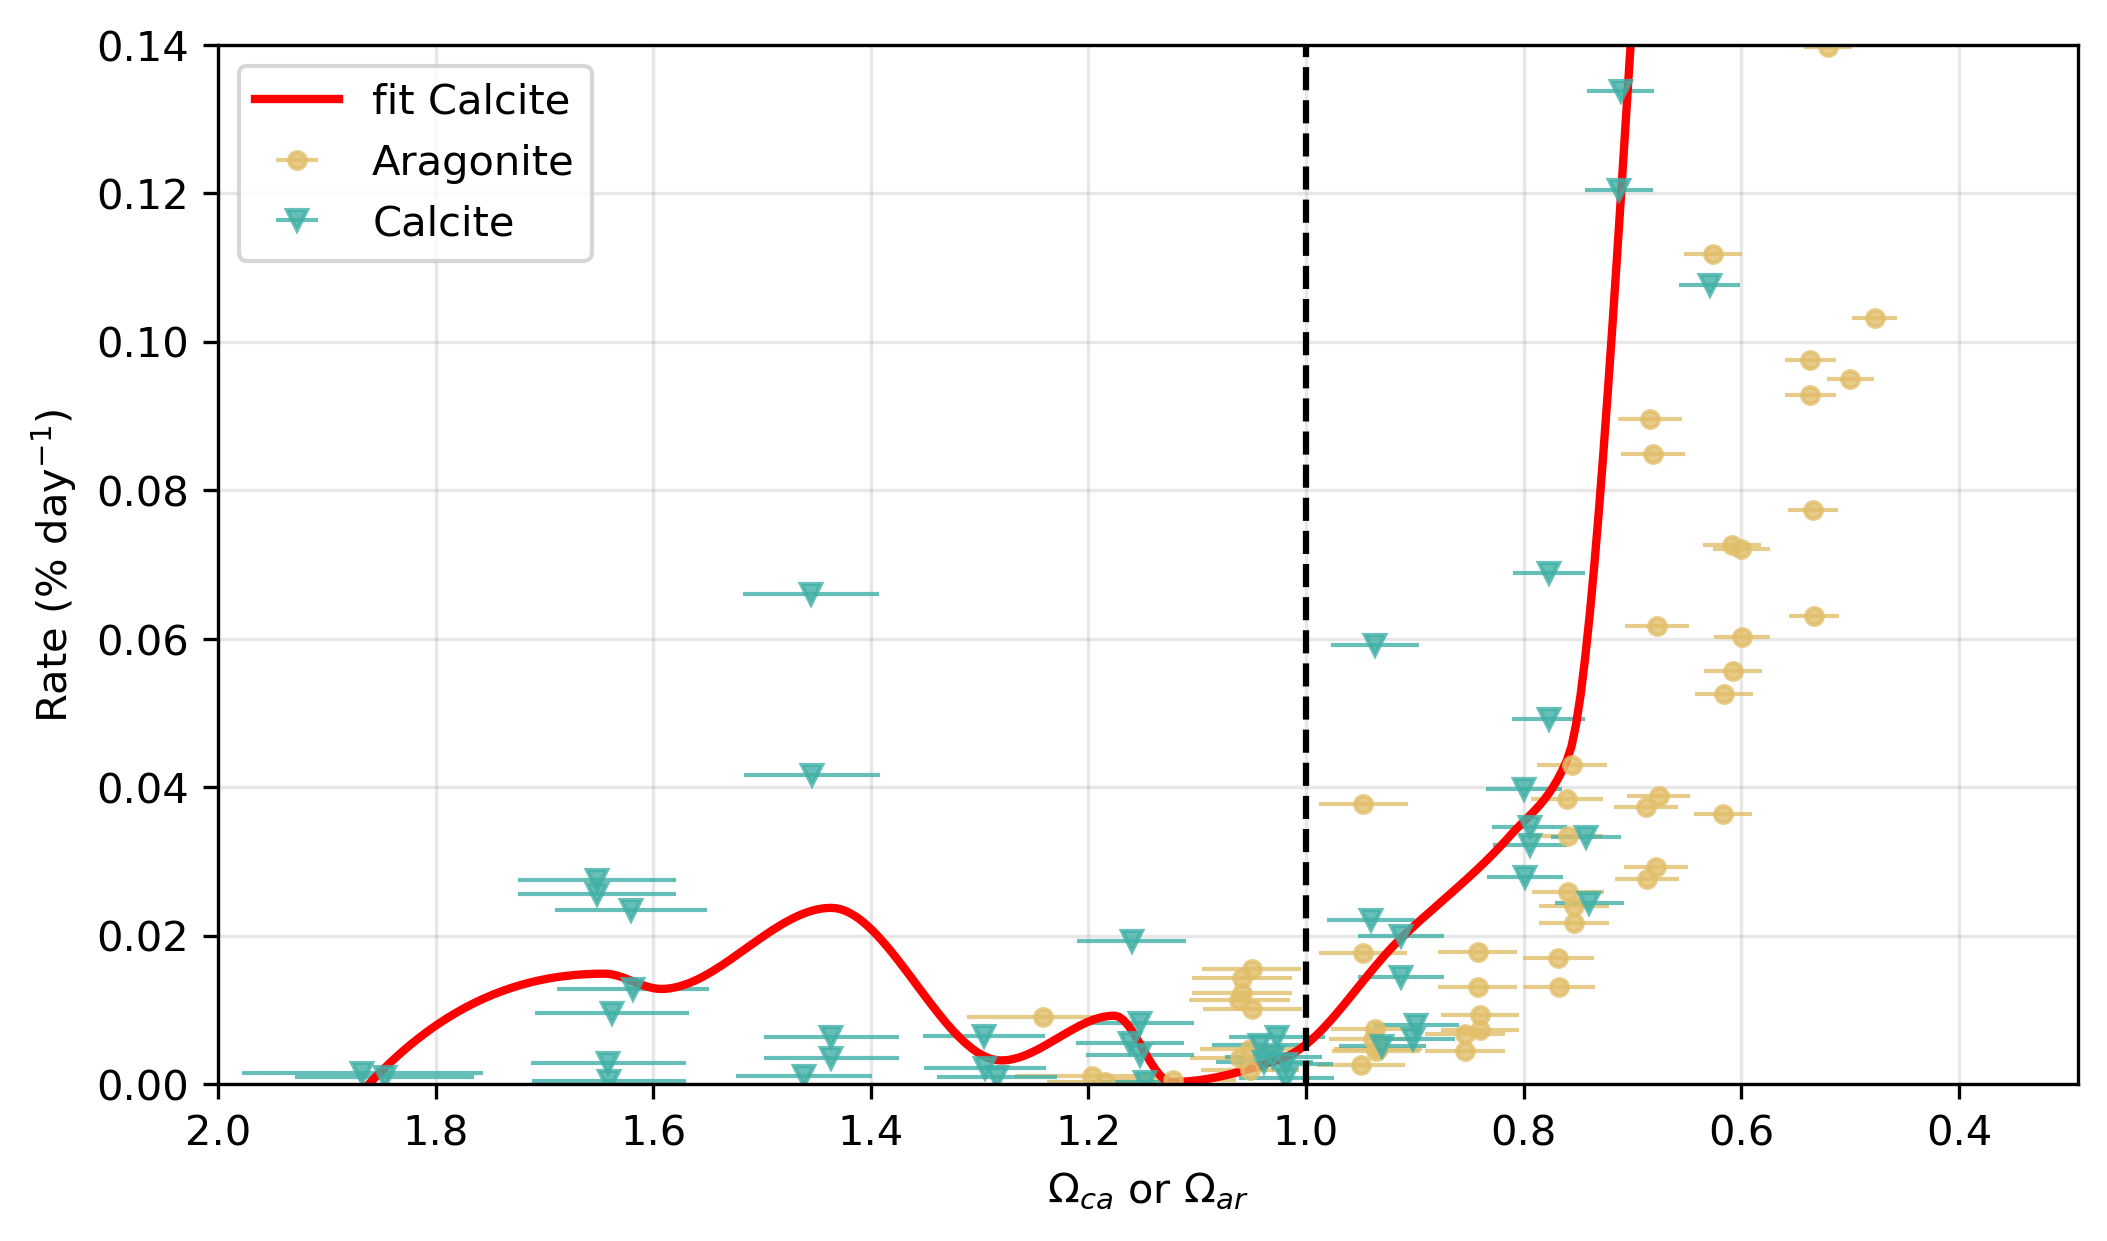

In [3]:
df_m77_ca = df[(df['Source_abbrev'] == 'M77') & (df['Material'] == 'Calcite')].copy()


plt.figure(dpi=300, figsize=(8,4.5))
  
df_m77_m = df_m77[df_m77.Material == 'Aragonite']
plt.errorbar(df_m77_m['Omega_calc23'], df_m77_m['Rate_mass'], 
             xerr=df_m77_m['u_Omega_calc23'], fmt='.', label='Aragonite', 
             alpha=0.8, linewidth=1, ms=8, color='#E1BE6A')

    
df_m77_m = df_m77[df_m77.Material == 'Calcite']
plt.errorbar(df_m77_m['Omega_calc23'], df_m77_m['Rate_mass'], 
             xerr=df_m77_m['u_Omega_calc23'], fmt='v', label='Calcite', 
             alpha=0.8, linewidth=1, ms=5, color='#40B0A6')


# make the fit
df_m77_ca['x_bin'] = pd.cut(df_m77_ca['Oca_calc23'], 
                     bins=pd.interval_range(start=df_m77_ca['Oca_calc23'].min(), 
                                            end=df_m77_ca['Oca_calc23'].max()+0.05, 
                                            freq=0.05))
# Calculate the average of 'y' for each bin
result = df_m77_ca.groupby('x_bin')['Rate_mass'].mean()
x_values = result.index.map(lambda x: (x.right+x.left)/2)

df_bins = pd.DataFrame(data={'x_bin': x_values, 'Rate_mass_avg': result.values})
df_bins = df_bins.dropna()
interp = PchipInterpolator(df_bins.x_bin, df_bins.Rate_mass_avg, extrapolate=True)
x_interp = np.linspace(df_bins.x_bin.min()-0.01, df_bins.x_bin.max()+0.1, 300)
plt.plot(x_interp, interp(x_interp), color='red', label='fit Calcite', linewidth=2)


plt.axvline(1, color='black', linestyle='--')

plt.gca().invert_xaxis()
plt.xlabel('$\Omega_{ca}$ or $\Omega_{ar}$')
plt.ylabel('Rate (% day$^{-1}$)')
plt.ylim(0,0.14)
plt.xlim(2)
#plt.xlim(0.65)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Metabolic saturation state (Figure 11)

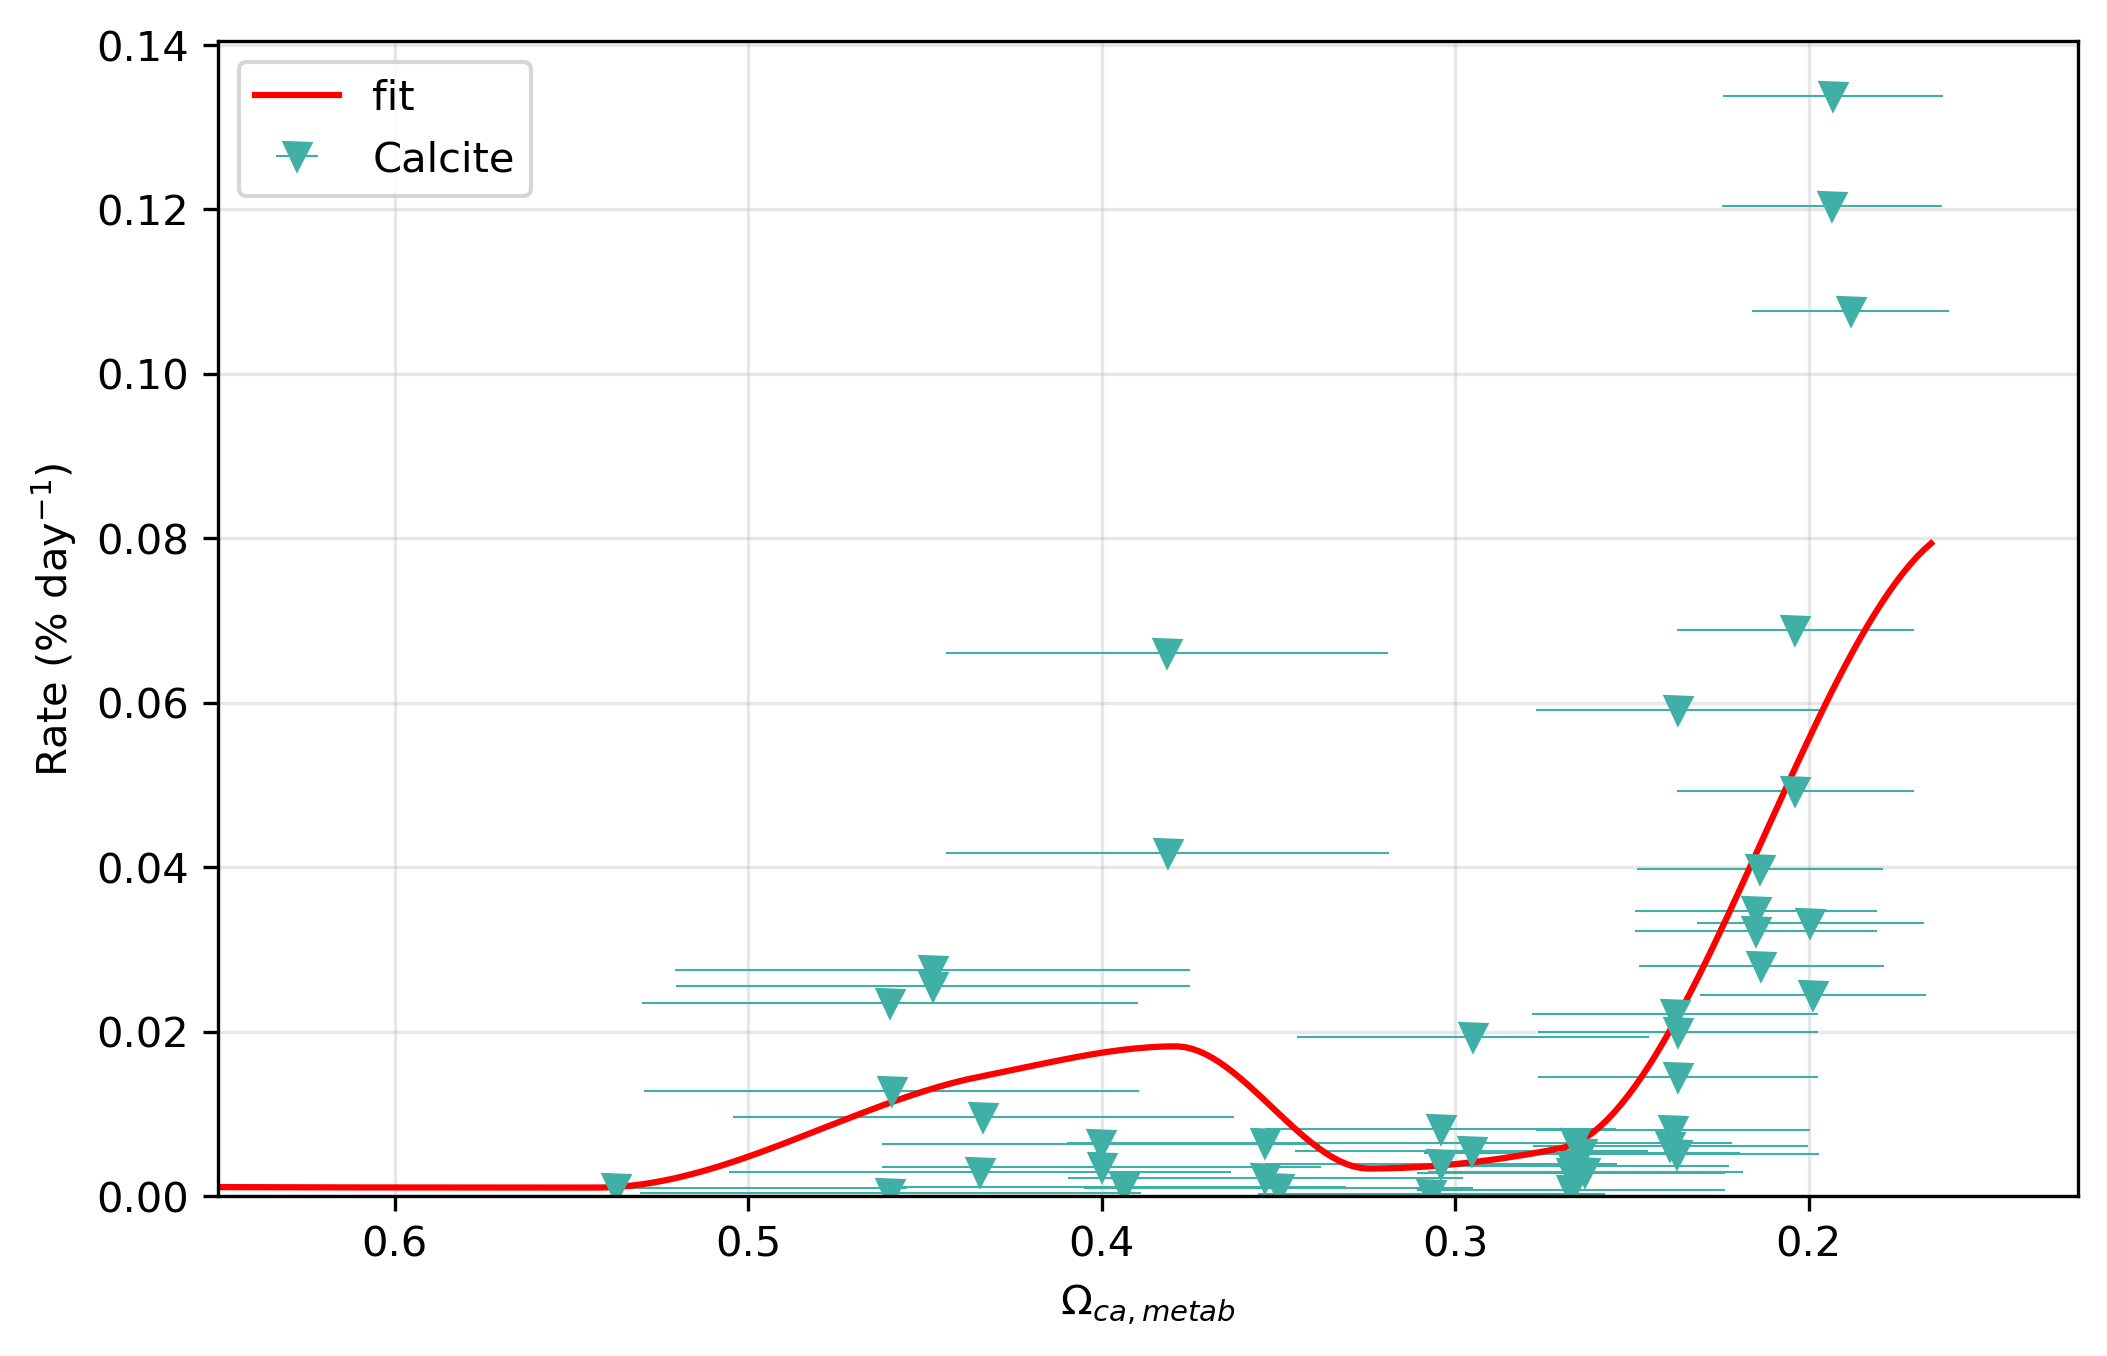

In [4]:
plt.figure(dpi=300, figsize=(8,5))


df_m77_ca = df[(df['Source_abbrev'] == 'M77') & (df['Material'] == 'Calcite')].copy()

bins = pd.interval_range(start=df_m77_ca['Oca_metab_calc12'].min(), 
                                            end=df_m77_ca['Oca_metab_calc12'].max()+0.05, 
                                            freq=0.05)

df_m77_ca['x_bin'] = pd.cut(df_m77_ca['Oca_metab_calc12'], 
                     bins=bins)

# Calculate the average of 'y' for each bin
result = df_m77_ca.groupby('x_bin')['Rate_mass'].mean()
x_values = result.index.map(lambda x: (x.right+x.left)/2)

df_bins = pd.DataFrame(data={'x_bin': x_values, 'Rate_mass_avg': result.values})
df_bins = df_bins.dropna()

# Display the result
#plt.scatter(x_values, result.values)

plt.errorbar(df_m77_ca['Oca_metab_calc12'], df_m77_ca['Rate_mass'], xerr=df_m77_ca['u_Omega_calc23'], 
             fmt='v', linewidth=0.5, label='Calcite', color='#40B0A6')

interp = PchipInterpolator(df_bins.x_bin, df_bins.Rate_mass_avg, extrapolate=True)
x_interp = np.linspace(df_bins.x_bin.min()-0.05, df_bins.x_bin.max(), 300)
plt.plot(x_interp, interp(x_interp), color='red', label='fit')


plt.gca().invert_xaxis()
plt.xlabel('$\Omega_{ca,metab}$')
plt.ylabel('Rate (% day$^{-1}$)')
plt.ylim(0)
plt.xlim(0.65)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ratio Ca:CO3

In [5]:
results = pyco2.sys(df['DIC_cb'], df['pH_insitu_cb'], 2, 3, salinity=df['Sal_woa'], temperature=df['Temp_woa'])


df['calcium'] = results['total_calcium']
df['co3'] = results['CO3']

df['ca:co3'] = df['calcium']/df['co3']

df_m77 = df[(df['Source_abbrev'] == 'M77')]
print(df_m77['ca:co3'].min())
print(df_m77['ca:co3'].max())
print(df_m77['ca:co3'].mean())

59.84210534794953
183.41673549038106
138.06865517681962
